# Text2Cypher Workflow Demo Notebook

This notebooks demonstrates a text2cypher workflow with visualization capabilities.

This notebook uses an LLM to perform some of the Cypher validation. 

In [1]:
import sys
DIR_SHIFT = "../../"
sys.path.append(DIR_SHIFT)

## Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import asyncio 
from IPython.display import Image, display

from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from ps_genai_agents.workflows.multi_agent import create_text2cypher_with_viz_and_follow_ups_workflow
from ps_genai_agents.components.state import OutputState
from ps_genai_agents.retrievers.cypher_examples import YAMLCypherExampleRetriever

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

## Neo4j Graph

This class handles interaction with our Neo4j database. We use `enhanced_schema` to gain more detail about the graph contents.

In [5]:
graph = Neo4jGraph(enhanced_schema=True)

In [6]:
print(graph.schema)

Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Question**
  - `id`: INTEGER Min: 1, Max: 223
  - `question`: STRING Example: "#001 Doors Hard to Open/Close"
- **Vehicle**
  - `id`: STRING Example: "Acura Integra"
  - `totalProblems`: INTEGER Min: 2, Max: 10
- **Verbatim**
  - `id`: STRING Example: "9A79438B"
  - `verbatim`: STRING Example: "When the doors are locked and the driver's door is"
  - `verbatimText`: STRING Example: "acura integra exterior ext01: doors - hard to open"
  - `severity`: FLOAT Example: "1.0"
  - `gender`: STRING Example:

## LLM

We will be using an OpenAI LLM for this demo.

In [7]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Cypher Example Retriever

This class is responsible for collecting and formatting Cypher examples for few shot prompting.

In [8]:
cypher_query_yaml_file_path = DIR_SHIFT+"./data/iqs/queries/queries.yml"
cypher_example_retriever = YAMLCypherExampleRetriever(cypher_query_yaml_file_path=cypher_query_yaml_file_path)

## Agent

In [9]:
scope_description = "This application may answer questions related to customer feedback on Honda vehicles."

In [10]:
agent = create_text2cypher_with_viz_and_follow_ups_workflow(llm=llm, 
                                                       graph=graph, 
                                                       scope_description=scope_description, 
                                                       llm_cypher_validation=False,
                                                       cypher_example_retriever=cypher_example_retriever, 
                                                       attempt_cypher_execution_on_final_attempt=True)

Here we can see the agent workflow. 
* The workflow always starts at `guardrails` where the input question is determined to be in scope or not.
* The workflow always ends at `final_answer` where the generated contents are formatted to be returned to the user.
* Dotted lines indicate conditional paths.

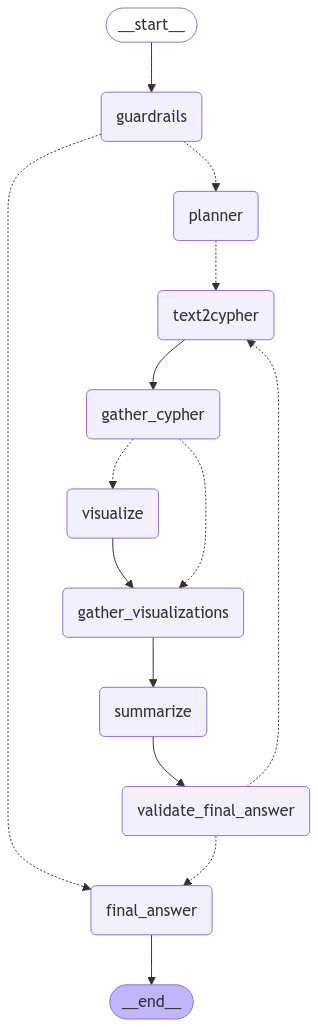

In [11]:
display(Image(agent.get_graph().draw_mermaid_png()))

We can see more detail of the Text2Cypher and Visualize subgraphs below.

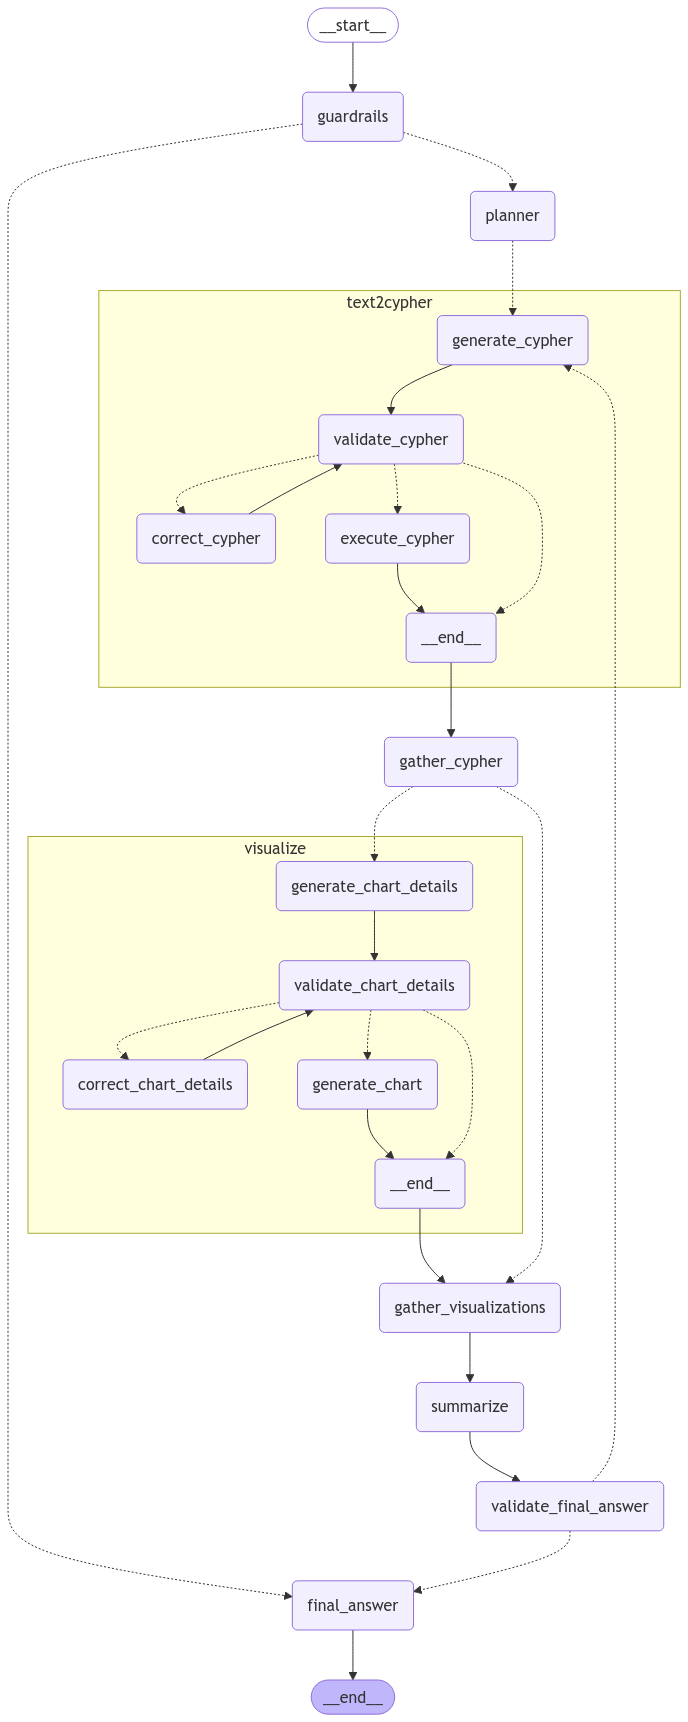

In [12]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Questions

### Helper Functions

In [20]:
async def ask_question(question: str, debug: bool = False) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    async def ask():
        response = await agent.ainvoke({"question": question}, debug=debug)
        return response

    return asyncio.run(ask())


def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))

def print_cypher_queries(response: OutputState) -> None:

   [print(c.get("task") + "\n\n" + c.get("statement")+"\n\n") for c in response.get("cyphers")]

def print_cypher_results(response: OutputState) -> None:

    [(print(c.get("task") + "\n\n"), [print(r) for r in c.get("records")], print("\n\n")) for c in response.get("cyphers")]

def print_viz_results(response: OutputState) -> None:
    [
        (print(v.get("task") + "\n\n" + v.get("chart_description") + "\n\n"), display(v.get("chart"))) for v in response.get("visualizations")
    ]

def print_steps(response: OutputState) -> None:
    [
        print(step) for step in response.get("steps")
    ]

def print_history(response: OutputState) -> None:
    print("History")
    [
        (print("Question: " + h.get("question", "none") + "\n" + "Answer: " + h.get("answer", "none") + "\nCyphers:"), [print(f"{c.get("task", "")}\n\n{c.get("statement", "")}\n\nNum records: {len(c.get("records", list()))}") for c in h.get("cyphers", list())]) for h in response.get("history")
    ]

The agent response is a Python dictionary with the following format:
```python
{
    answer: str,
    question: str,
    steps: List[str],
    cyphers: List[
        subquestion: str,
        statement: str,
        errors: List[str],
        records: List[Dict[str, Any]],
        next_action: str,
        steps: List[str],
    ],
    visualizations: List[
        subquestion: str
        chart: Any
        chart_description: str
        steps: List[str]
    ]
}
```

### 1. Out of Scope

The agent can detect whether a question is in scope and avoid further processing.

In [14]:
q1 = await ask_question("What are the most common apple types?")

In [15]:
print_answer(q1)

What are the most common apple types?
This question is out of scope. Therefore I cannot answer this question.


We can see the agent only performs 2 steps - only `guardrails` requires an LLM call.

In [21]:
print_steps(q1)

guardrails
final_answer


### 2. Cypher Question without Visualization

The agent is capable of creating Cypher queries to answer questions within the scope of the data.

In [17]:
q2 = await ask_question("How many vehicles are there?")

In [18]:
print_answer(q2)

How many vehicles are there?
There are 12 vehicles.


All Cypher queries are saved for evaluation.

In [19]:
print_cypher_queries(q2)

What is the total number of vehicles?

MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles




Results are saved as well for evaluation or futher processing.

In [33]:
print_cypher_results(q2)

What is the total number of vehicles?


{'totalVehicles': 12}





History may also be tracked.

In [34]:
print_history(q2)

History
Question: How many vehicles are there?
Answer: There are 12 vehicles.
Cyphers:
What is the total number of vehicles?

MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles

Num records: 1


### 3. Multi-Cypher Query Question without Visualization

The agent is capable of splitting the input question into multiple subquestions. These will be individually addressed with their own Cypher queries. 
The final answer will summarize the query results together.

In [22]:
q3 = await ask_question("Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?", debug=False)

In [23]:
print_answer(q3)

Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?
- **Summary of Responses for FCD10:**
  - Users report that the touch system to lock and unlock doors is unreliable, often requiring multiple attempts or manual intervention.
  - Some users experience issues where doors do not unlock from the outside, even when using the key fob or manual controls.
  - The auto-lock feature sometimes fails to lock the doors, leading to security concerns.
  - There are instances where the door locks instead of unlocking when touched, causing frustration.
  - If someone tries to open the door while unlocking, it can cause a temporary lockout.

- **Men to Women Proportion:**
  - Male to Female Ratio: 0.4

- **Problem for FCD10:**
  - Door locks - Broken/work inconsistently


In [24]:
print_cypher_queries(q3)

Summarize the responses under fcd10 for Honda Pilot.

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
RETURN v.verbatim AS responseSummary


What is the men to women proportion for the responses under fcd10 for Honda Pilot?

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
WITH COUNT(v) AS totalResponses, 
     SUM(CASE WHEN v.gender = "Male" THEN 1 ELSE 0 END) AS males,
     SUM(CASE WHEN v.gender = "Female" THEN 1 ELSE 0 END) AS females
RETURN totalResponses, males, females, toFloat(males) / (CASE WHEN females = 0 THEN 1 ELSE females END) AS maleToFemaleRatio


What is the problem for fcd10 in Honda Pilot?

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
RETURN p.problem AS problem




### 4. Question with Visualization

If visualization is requested, the agent will attempt to create either a bar, line or scatter plot to fit the results gathered from Neo4j.

In [ ]:
q4 = await ask_question("Show me which makes have the most responses.", debug=False)

We recieve a description along with each generated chart.

Which car makes have the most responses?

This bar chart displays the total number of responses for each car make. It compares the response counts between Honda and Acura, showing which make has more responses.




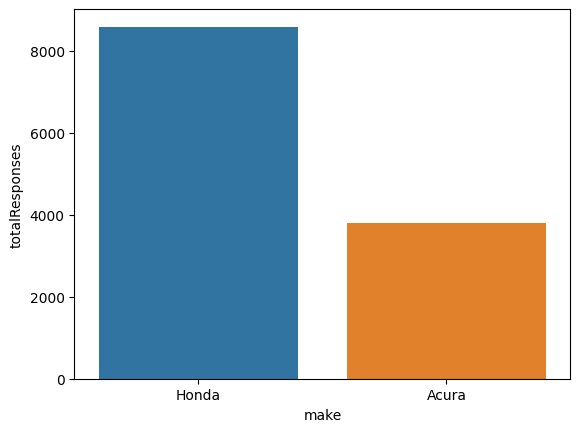

In [37]:
print_viz_results(q4)

We still recieve everything else in the result such as the summary and Cypher info.

In [38]:
print_answer(q4)

Show me which makes have the most responses.
- **Honda**: 8589 responses
- **Acura**: 3791 responses


In [39]:
print_cypher_queries(q4)

Which car makes have the most responses?

MATCH (v:Verbatim)
RETURN v.make AS make, COUNT(v) AS totalResponses
ORDER BY totalResponses DESC


